# S05 T01 Expresiones regulares y parseo de logs

## Exercici 1
Obtener los datos y separarlos en columnas

In [1]:
import pandas as pd
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# leo el archivo completo y lo cargo en f
# Pongo '\n' como separador porque en algunas líneas había 2 \n seguidos y daba error al leerlas
# De todas formas no quería un separador a esta altura porque tengo líneas diferentes, como:
# localhost 127.0.0.1 - - [23/Feb/2014:03:10:31 +0100] "OPTIONS * HTTP/1.0" 200 - "-" "Apache (internal dummy connection)" VLOG=-
# www.akumenius.com 66.249.76.216 - - [23/Feb/2014:03:10:40 +0100] "GET /hoteles-baratos/ofertas-hotel-Howard-Jhonson-hotel-&-Spa--Villa-Gral-Belgrano-en-Villa%20General%20Belgrano-146416b-destinos.html HTTP/1.1" 404 3100 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)" VLOG=-

# f = pd.read_csv("Web_access_log-akumenius.com.txt", header = None, sep='\n')
f = open("Web_access_log-akumenius.com.txt", "r")


## De cada línea del archivo se obtiene:
* sitio: dirección de destino
* ip: dirección que origina el comando
* fecha
* comando: comando que se ejecutó
* parametros: parámetros del comando ejecutado
* vlog: contenido del VLOG

In [3]:
# creo el dataframe vacío
log_df = pd.DataFrame(columns = ['sitio', 'ip', 'fecha', 'comando', 'parametros', 'vlog'])

# leo la primera línea
lin = f.readline()


In [4]:
while lin:
    # separo la línea en dos partes
    mitad1, mitad2 = re.split('"',lin , 1)
    mitad2 = mitad2.rstrip('\n')
    #print(mitad2)

    # busco el sitio web y la dirección ip de origen del comando
    sitio, ip, resto = re.split(' ',mitad1 , 2)
    #print('Sitio:', sitio, 'IP:', ip)

    # en la primera mitad sólo me queda la fecha
    fecha = re.search('\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2}\s{1}\+{1}\d{4}', resto).group(0)
    fecha_dt = datetime.strptime(fecha, '%d/%b/%Y:%H:%M:%S +%f')
    #print('Fecha:', fecha_dt.strftime("%c"))

    # analizo la segunda mitad, busco el comando y el VLOG
    tercios = mitad2.rpartition('VLOG=')
    vlog = tercios[2]
    #print(vlog)
    
    # el |- es porque hay comandos 'nulos' en vez de un nombre tienen -        
    cmd = re.search('^[A-Z]+|-', tercios[0])
    
    if cmd is None:
        # no hay un comando (porque siempre empiezan con letras)
        continue
    
    comando = cmd.group(0)
    #print(comando)

    # lo que queda en el medio son los parámetros del comando
    parametros = tercios[0].rpartition(comando)[2]
    #print(parametros)
    
    # guardo los datos de la línea en el dataframe
    log_df = log_df.append({'sitio': sitio, 'ip': ip, 'fecha': fecha_dt, 'comando': comando, 
                            'parametros': parametros, 'vlog': vlog}, ignore_index=True)

    lin = f.readline()
f.close()  
print('Dataframe completado')


Dataframe completado


## Exercici 2
Limpiar y preprocesar los datos

In [5]:
log_df.shape

(261873, 6)

In [6]:
# esto me va a servir para imprimir la fecha fecha_dt.strftime("%c")
# miro algunas líneas del df:
print(log_df.head(25))

                sitio             ip                   fecha  comando  \
0           localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
1           localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
2           localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
3           localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
4           localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
5           localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
6           localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
7           localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
8           localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
9           localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
10          localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
11          localhost      127.0.0.1 2014-02-23 03:10:31.010  OPTIONS   
12          localhost      127.0.0.1 2014-02-23 03:

In [8]:
# aprecen solo 5 comandos, pero uno es '-'
pd.unique(log_df['comando'].values)

array(['OPTIONS', 'GET', 'HEAD', 'POST', '-'], dtype=object)

In [9]:
# elimino los comandos '-' porque no aportan 
# tienen la forma
# 7916	localhost	62.175.136.122	2014-02-24 13:08:00.010	-	"	-
# 7921	localhost	62.175.136.122	2014-02-24 13:08:01.010	-	"	-
filtro = log_df['comando'] != '-'
log_df = log_df.loc[filtro]

In [10]:
pd.unique(log_df['comando'].values)

array(['OPTIONS', 'GET', 'HEAD', 'POST'], dtype=object)

In [14]:
pd.unique(log_df['sitio'].values)

array(['localhost', 'www.akumenius.com', 'akumenius.com', 'akumenius.es',
       'test.akumenius.com'], dtype=object)

In [16]:
    # dibujo los sitios que acceden los usuarios
    # calculate the values to display (counts)
    counts = log_df['sitio'].value_counts()
    
    counts

www.akumenius.com     232300
test.akumenius.com     14610
localhost              14085
akumenius.com            742
akumenius.es              94
Name: sitio, dtype: int64

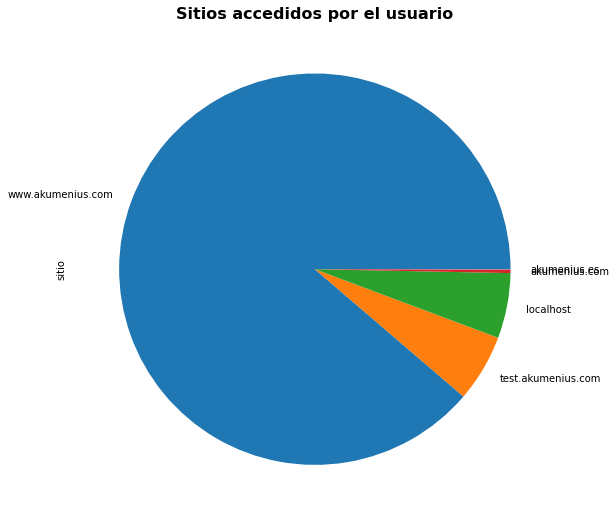

In [17]:
    # use a pie plot
    counts_bar = counts.plot(kind='pie', y=log_df['sitio'], figsize =(9, 9))
    
    # set titles
    counts_bar.set_title("Sitios accedidos por el usuario", fontsize=16, weight="bold")
    plt.show()

In [18]:
# Puedo eliminar los 'localhost' ya que se trata de pruebas locales
filtro = log_df['sitio'] != 'localhost'
log_df = log_df.loc[filtro]
log_df.shape

(247746, 6)

In [19]:
pd.unique(log_df['vlog'].values)

array(['-'], dtype=object)

In [20]:
# elimino la columna vlog porque sólo aparece el valor '-'
log_df = log_df.drop(['vlog'], axis=1)
log_df

,sitio,ip,fecha,comando,parametros
22,www.akumenius.com,66.249.76.216,2014-02-23 03:10:31.010,GET,/hoteles-baratos/ofertas-hotel-Club-&-Hotel-L...
23,www.akumenius.com,66.249.76.216,2014-02-23 03:10:33.010,GET,/hoteles-baratos/ofertas-hotel-Metropolis-Hot...
24,www.akumenius.com,66.249.76.216,2014-02-23 03:10:35.010,GET,/hoteles-baratos/ofertas-hotel-Faena-Hotel-Bu...
25,www.akumenius.com,66.249.76.216,2014-02-23 03:10:38.010,GET,/hoteles-baratos/ofertas-hotel-Kensington-Tow...
26,www.akumenius.com,66.249.76.216,2014-02-23 03:10:39.010,GET,/destinos-baratos/destinosEstrelles/hoteles-e...
...,...,...,...,...,...
261865,akumenius.com,5.255.253.53,2014-03-02 03:05:35.010,GET,"/ HTTP/1.1"" 301 301 ""-"" ""Mozilla/5.0 (compati..."
261866,www.akumenius.com,5.255.253.53,2014-03-02 03:05:34.010,GET,"/ HTTP/1.1"" 200 7528 ""-"" ""Mozilla/5.0 (compat..."
261867,akumenius.es,5.255.253.53,2014-03-02 03:05:35.010,GET,"/ HTTP/1.1"" 301 304 ""-"" ""Mozilla/5.0 (compati..."
261868,www.akumenius.com,5.255.253.53,2014-03-02 03:05:39.010,GET,"/ HTTP/1.1"" 200 7528 ""-"" ""Mozilla/5.0 (compat..."


In [21]:
# que forma tienen los accesos a test.akumenius.com, parece un sitio de test 
log_df.loc[log_df['sitio'] == 'test.akumenius.com']

,sitio,ip,fecha,comando,parametros
25071,test.akumenius.com,174.129.237.157,2014-02-23 17:14:31.010,GET,"/robots.txt HTTP/1.0"" 200 819 ""-"" ""ia_archive..."
25072,test.akumenius.com,174.129.237.157,2014-02-23 17:14:31.010,GET,/hoteles-baratos/ofertas-hoteles-en-grecia.ht...
25095,test.akumenius.com,174.129.237.157,2014-02-23 17:15:35.010,GET,"/newdesign/faq HTTP/1.0"" 200 16976 ""-"" ""ia_ar..."
46068,test.akumenius.com,174.129.237.157,2014-02-24 04:42:46.010,GET,"/robots.txt HTTP/1.0"" 200 819 ""-"" ""ia_archive..."
46602,test.akumenius.com,174.129.237.157,2014-02-24 05:24:47.010,GET,/escapadas/navidad-fin-de-a-972.html HTTP/1.0...
...,...,...,...,...,...
257530,test.akumenius.com,80.39.210.69,2014-03-01 20:03:30.010,GET,/newdesign/libraries/jqueryui/css/ui-lightnes...
259814,test.akumenius.com,174.129.237.157,2014-03-01 23:08:43.010,GET,"/escapadas/culturales-499.html HTTP/1.0"" 200 ..."
260112,test.akumenius.com,174.129.237.157,2014-03-01 23:40:37.010,GET,"/escapadas/rural-974.html HTTP/1.0"" 200 71578..."
260490,test.akumenius.com,174.129.237.157,2014-03-02 00:00:35.010,GET,"/escapadas/lugo-545.html HTTP/1.0"" 200 33747 ..."


In [22]:
    # dibujo los comandos que usan los usuarios
    # calculate the values to display (counts)
    counts = log_df['comando'].value_counts()
    
    counts

GET     229336
POST     16646
HEAD      1764
Name: comando, dtype: int64

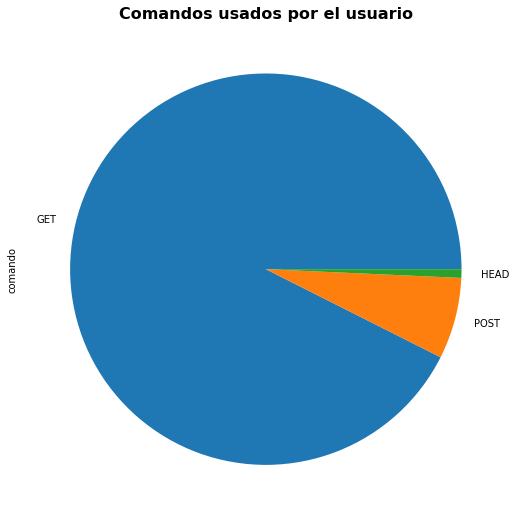

In [23]:
    # use a pie plot
    counts_bar = counts.plot(kind='pie', y=log_df['comando'], figsize =(9, 9))
    
    # set titles
    counts_bar.set_title("Comandos usados por el usuario", fontsize=16, weight="bold")
    plt.show()

### La mayoría de los comandos son GET y a la dirección www.akumenius.com

In [27]:
# hay valores vacíos?
log_df.isna().sum()

sitio         0
ip            0
fecha         0
comando       0
parametros    0
dtype: int64

In [45]:
# desde cuántas direcciones distintas se accedió a las páginas?
ip_unicas = pd.unique(log_df['ip'].values)
len(ip_unicas)


2858

In [85]:
#log_df.groupby(['sitio','ip']).count()
g= log_df.groupby(['sitio','ip'], axis=0).agg({'ip': [len]}).rename(columns={"len": "cant"})
g

ip
                                  cant
sitio             ip                  
akumenius.com     108.168.250.12     1
                  109.200.159.118    1
                  109.208.120.233    1
                  109.211.53.111     1
                  109.217.107.218    1
...                                ...
www.akumenius.com 95.63.234.126    264
                  95.63.60.249     154
                  96.242.31.129     52
                  98.137.206.41     11
                  98.244.10.248     91

[3170 rows x 1 columns]

### Obtener los datos de geolocalización
Utilizo ip-api para obtener los datos de geolocalización
Sólo tomo las 6 IPs que más consultas hicieron porque la API tiene un límite de consultas gratuitas

In [111]:
import requests
import json
import pandas as pd

# URL de la API usada para geolocalización
api_url = "http://ip-api.com/json/"


res = g.apply(lambda x: x.sort_values(ascending=False).head(6))
res

ip
                                     cant
sitio              ip                    
www.akumenius.com  66.249.76.216    46382
test.akumenius.com 80.28.221.123    12982
www.akumenius.com  217.125.71.222    3995
                   66.249.75.148     3558
                   162.243.192.191   2927
                   62.117.197.230    2567

In [112]:
res = res.reset_index()

res

sitio               ip       
                                         cant
0   www.akumenius.com    66.249.76.216  46382
1  test.akumenius.com    80.28.221.123  12982
2   www.akumenius.com   217.125.71.222   3995
3   www.akumenius.com    66.249.75.148   3558
4   www.akumenius.com  162.243.192.191   2927
5   www.akumenius.com   62.117.197.230   2567

In [117]:
res.columns

MultiIndex([('sitio',     ''),
            (   'ip',     ''),
            (   'ip', 'cant')],
           )

In [120]:
ips = res[(   'ip',     '')]
ips

0      66.249.76.216
1      80.28.221.123
2     217.125.71.222
3      66.249.75.148
4    162.243.192.191
5     62.117.197.230
Name: (ip, ), dtype: object

In [122]:
# la función que hace la conexión con la API de geolocalización
# devulve todos los datos de la IP en formato JSON

def ip_scraping(ip=""):
 # Conexión con la API
 res = requests.get(api_url+ip, data=data)
 # Obtenemos y procesamos la respuesta JSON
 api_json_res = json.loads(res.content)
 return api_json_res

In [124]:
# Definimos los parametros de respuesta que queremos obtener
parametros = 'country,countryCode,city,lat,lon,isp,org'
data = {"fields":parametros}

for valor in ips:
    print('IP analizada: ', valor)
    # Llamamos a la función ip_scraping y mostramos los resultados
    par = parametros.split(",")
    if ip_scraping(valor)['status'] == 'success':
        for x in par:
          print(x.upper(), ":", ip_scraping(valor)[x])
    else:
        print('IP no encontrada')
    print('\n')

IP analizada:  66.249.76.216
COUNTRY : United States
COUNTRYCODE : US
CITY : Mountain View
LAT : 37.422
LON : -122.084
ISP : Google LLC
ORG : Google LLC


IP analizada:  80.28.221.123
COUNTRY : Spain
COUNTRYCODE : ES
CITY : Madrid
LAT : 40.5005
LON : -3.66739
ISP : TDENET (Red de servicios IP)
ORG : 


IP analizada:  217.125.71.222
COUNTRY : Spain
COUNTRYCODE : ES
CITY : Tocina
LAT : 37.6025
LON : -5.7307
ISP : Telefonica de Espana SAU
ORG : TDENET (Red de servicios IP)


IP analizada:  66.249.75.148
COUNTRY : United States
COUNTRYCODE : US
CITY : Mountain View
LAT : 37.422
LON : -122.084
ISP : Google LLC
ORG : Google LLC


IP analizada:  162.243.192.191
COUNTRY : United States
COUNTRYCODE : US
CITY : New York
LAT : 40.7316
LON : -73.9985
ISP : DigitalOcean, LLC
ORG : Digital Ocean


IP analizada:  62.117.197.230
COUNTRY : Spain
COUNTRYCODE : ES
CITY : Madrid
LAT : 40.4163
LON : -3.6934
ISP : Ono
ORG : ONO_HFC




## Exercici 3
Ir más allá...